In [36]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [37]:
path = '/Users/yehonatanperetz/histopathologic-cancer-detection/'
train_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/train/'
test_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/test/'

In [38]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [39]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220027
Test Size: 57458


In [40]:
label_counts = all_train_df.label.value_counts()
print(label_counts)



label
0    130908
1     89117
Name: count, dtype: int64


In [41]:
# Number of samples in each class
SAMPLE_SIZE = 5000


# Use 80000 positive and negative examples
df_label0 = all_train_df[all_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_label1 = all_train_df[all_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_label0, df_label1], axis=0).reset_index(drop=True))

train_df.shape

(10000, 2)

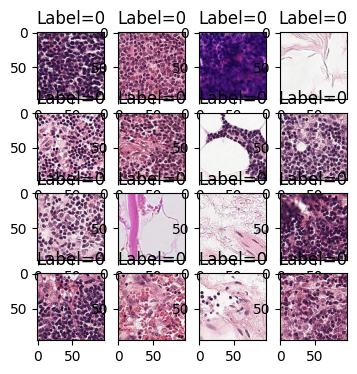

In [42]:
#print(train_df.head(2))
#print(train_imgs[1])
N_plot=4
fig = plt.figure(figsize=(N_plot, N_plot)) 

for i in range(1,N_plot**2+1):
        img=Image.open(train_path+train_df['id'][i]+'.tif')
        fig.add_subplot(N_plot, N_plot, i)
        plt.imshow(img)
        plt.title('Label=%s'%train_df['label'][i])
    

        



In [43]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'][0:N])
    for i in range(0,N):
        img=Image.open(train_path+df['id'][i]+'.tif')
        img_rgb = img.convert('RGB')
        X[i] = np.array(img_rgb)
    return X,y

In [44]:

img=Image.open(train_path+'lines_proto.tiff')
img_rgb = img.convert('RGB')
x0 = np.array(img_rgb)

img=Image.open(train_path+'x_proto.tiff')
img_rgb = img.convert('RGB')
x1 = np.array(img_rgb)

def generate_data(N):
# Loading N images from df dataframe
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.zeros([N,1],dtype=np.uint8);
    for i in range(0,N):
        if i%2==0:
            X[i] = x0+np.random.normal(0,2/2,(96,96,3))
            y[i]=np.int32(0)
        else:
            X[i] = x1+np.random.normal(0,60/2,(96,96,3))
            y[i]=np.int32(1)

    return X,y

In [45]:
def convert_binary_to_two_class(y):
    N=len(y);
    y2 = np.zeros([N,2],dtype=np.uint8) 
    y2[:,0]=y[:,0];
    y2[:,1]=1-y[:,0]
    return y2

    


In [46]:
load_fake_data=False
if load_fake_data==False: 
    X,y = load_data(N=2*SAMPLE_SIZE,df=train_df)
    y=np.reshape(y,[len(y),1])
    print(X.shape)
    print(y.shape)

(10000, 96, 96, 3)
(10000, 1)


In [47]:
if load_fake_data==True: 
    X,y = generate_data(N=2*SAMPLE_SIZE) 
    print(X.shape)
    print(y.shape)

In [48]:
#y=convert_binary_to_two_class(y)
print(y.shape)

(10000, 1)


In [49]:
print(y[0:10,:])

[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

[0]


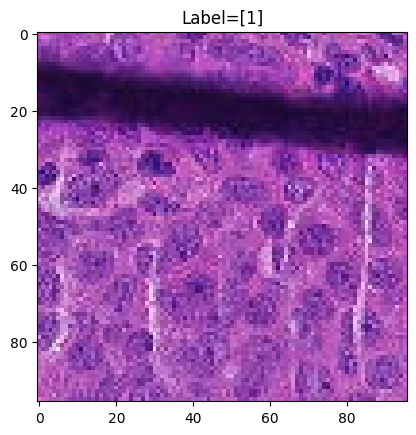

In [51]:
k=14
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

[1]


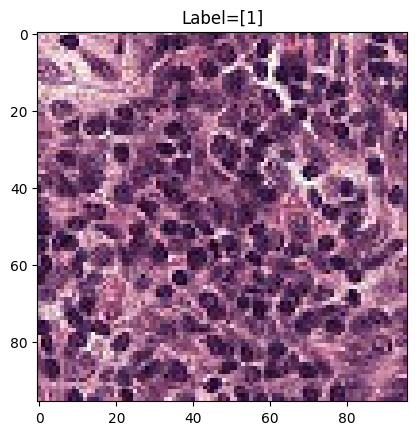

In [52]:
k=18
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

In [53]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(6700, 96, 96, 3)
(6700, 1)
(3300, 96, 96, 3)
(3300, 1)


In [54]:
#create random batches for training

N_train=len(X_train)
batch_size=50;
N_batches=np.int32(np.floor(N_train/batch_size))
def random_batch(n, k, tot):
    start_points = np.sort(np.random.randint(0, tot-k, size=n))
    end_points = start_points + k
    end_points[:-1] = np.maximum(end_points[:-1], start_points[1:])
    return list(zip(np.int32(start_points), np.int32(end_points)))


batches=random_batch(N_batches,batch_size,N_train)
#print(len(batches))
#print(batches)


In [91]:

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(96, 96, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = keras.layers.Conv2D(128, (3,3), activation='relu')(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

#x = keras.layers.Dense(1024)(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dense(256)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_46 (InputLayer) │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_17 (Rescaling)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 3, 3, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_387 (Conv2D)         │ (None, 1, 1, 128)     │  2,359,424 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_17 │ (None, 128)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_15 (Dropout)        │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_34 (Dense)            │ (None, 512)           │     66,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_35 (Dense)            │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_36 (Dense)            │ (None, 1)             │        257 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,418,537 (89.33 MB)

 Trainable params: 2,557,057 (9.75 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [92]:
#model.summary()

In [93]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt, 
              metrics=['accuracy'])


In [94]:
N_epochs=3;


for epoch in range(1,N_epochs+1):
    model.fit(X_train,y_train, validation_data=(X_val,y_val))

210/210 ━━━━━━━━━━━━━━━━━━━━ 109s 503ms/step - accuracy: 0.5036 - loss: 7.4024 - val_accuracy: 0.4873 - val_loss: 8.0681
210/210 ━━━━━━━━━━━━━━━━━━━━ 104s 496ms/step - accuracy: 0.5048 - loss: 7.7497 - val_accuracy: 0.4876 - val_loss: 8.1637
210/210 ━━━━━━━━━━━━━━━━━━━━ 102s 484ms/step - accuracy: 0.5035 - loss: 7.8995 - val_accuracy: 0.4876 - val_loss: 8.1596
